In [2]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical

In [32]:
tf.__version__

'2.1.0'

In [18]:
import pandas as pd
from os import getcwd
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np

In [4]:
RANDOM_STATE = 42

In [5]:
PROJECT_PATH = getcwd()[:getcwd().find("notebooks")][:-1]
DATA_PATH = f"{PROJECT_PATH}\\data"
# path.append(f"{PROJECT_PATH}\\src")

In [6]:
reviews = pd.read_csv(f"{DATA_PATH}\\tripadvisor_hotel_reviews.csv")
reviews["Review"] = reviews["Review"].astype(str)
reviews = reviews.sample(frac=1, random_state = RANDOM_STATE)
reviews["Rating"] -= 1

In [7]:
reviews.head()

,Review,Rating
10726,not recommend hotel did reviewers actually sta...,0
14919,"barcelona rocks, stayed hotel jazz girlfriend ...",3
19098,ok hotel good location stayed night way beijin...,2
2450,great service nice pool ok beach lovely ground...,3
960,surprising treat spent weekend july 15/16 2006...,4


In [8]:
X = reviews["Review"]
y = reviews["Rating"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE)

In [10]:
pd.DataFrame([len(text) for text in X_train.values]).describe()

,0
count,14343.000000
mean,721.316600
std,680.744078
min,44.000000
25%,338.000000
50%,533.000000
75%,858.000000
max,12738.000000


In [11]:
count_vect =  CountVectorizer(max_features = 1000)

In [13]:
X_train_vect = count_vect.fit_transform(X_train.values) 
X_test_vect = count_vect.transform(X_test)

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X=X_train_vect, y=y_train.values)

DecisionTreeClassifier()

In [44]:
X_test

15139    average hotel great location room larger hong ...
14930    fault free hotel jazz stayed hotel jazz week d...
1136     excellent choice hotel hotel casablanca excell...
9668     excellent value husband stayed hotel nadia 2 n...
16592    average room great service stayed 13 nights pl...
                               ...                        
15025    best family vacation, just got intercontinenta...
5949     fantastic fantastic best way weekend millenium...
9842     avoid place stayed hotel basilea october 2004 ...
8790     freaking sweet price place stay amsterdam, tax...
6531     great locations chose orchard reviews rating t...
Name: Review, Length: 6148, dtype: object

In [47]:
accuracy_score(y_true=y_test, y_pred=dt.predict(X_test_vect))

0.4373780091086532

In [52]:
ab = AdaBoostClassifier(n_estimators=80)
ab.fit(X_train_vect, y_train)

AdaBoostClassifier(n_estimators=80)

In [53]:
accuracy_score(y_true=y_test, y_pred=ab.predict(X_test_vect))

0.5770982433311646

In [56]:
pipe = Pipeline([('count_vectorizer', CountVectorizer(max_features=1000)),
                 ('Adaboost', AdaBoostClassifier(n_estimators=50))])

In [58]:
pipe.fit(X=X_train, y = y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer(max_features=1000)),
                ('Adaboost', AdaBoostClassifier())])

In [59]:
pipe.score(X=X_test, y=y_test)

0.5590435914118412

# Neural Network

In [33]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(Input(shape=(X_train_vect.shape[1],)))
model.add(Dense(units=16, activation="sigmoid"))
model.add(Dense(units=5, activation="softmax"))
model.compile(optimizer="adam",
              loss=tf.keras.losses.categorical_crossentropy,  
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [35]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch = 0
        self.epochs = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.epochs.append(self.epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epoch += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

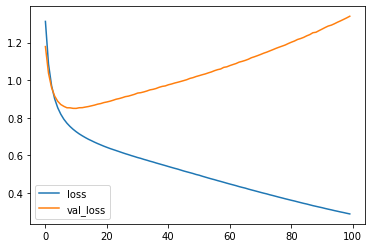

14343/14343 [==============================] - 1s 78us/sample - loss: 0.2890 - accuracy: 0.9133 - val_loss: 1.3399 - val_accuracy: 0.5898


In [36]:
model.fit(X_train_vect.toarray(),
          to_categorical(y_train), 
          validation_data = [X_test_vect.toarray(), to_categorical(y_test)],
          callbacks=[plot_losses], 
          batch_size=100,
          epochs=100)

In [30]:
accuracy_score(y_true=y_test, 
               y_pred=model.predict_classes(X_test_vect.toarray()))

0.5782368249837345